In [1]:
## Import the dependencies
import os
import shutil
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Flatten, Dense,Dropout
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

In [2]:
## Check whether GPU is available or not
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
TRAIN_DIR = 'PlantDiseaseDataset/Train/'
TEST_DIR = 'PlantDiseaseDataset/Test/'
VALIDATION_DIR = 'PlantDiseaseDataset/Validation/'

# Check how many classes are there
print(f"There are {len(os.listdir(TRAIN_DIR))} classes in the dataset")


There are 3 classes in the dataset


In [4]:
# Create training and validation datagenerator
def train_val_generator(TRAIN_DIR, VAL_DIR):
    train_datagen = ImageDataGenerator(rescale=1.0/255.,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')
    
    train_generator = train_datagen.flow_from_directory(directory = TRAIN_DIR,
                                                       batch_size = 32,
                                                       class_mode = 'categorical',
                                                       target_size = (256,256))
    
    val_datagen = ImageDataGenerator(rescale = 1.0/255.)
    
    val_generator = val_datagen.flow_from_directory(directory = VAL_DIR,
                                                   batch_size = 32,
                                                   class_mode = 'categorical',
                                                   target_size = (256, 256))
    return train_generator, val_generator

In [5]:
train_generator, validation_generator = train_val_generator(TRAIN_DIR, VALIDATION_DIR)

Found 1322 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [6]:
## Download the InceptionV3 model weights

!python -m wget https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


Saved under inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


In [7]:
local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [8]:
# Initialize the base model.
# Set the input shape and remove the dense layers.
pretrained_model = InceptionV3(input_shape = (256,256,3),
                              include_top = False,
                              weights = None)

pretrained_model.load_weights(local_weights_file)

for layer in pretrained_model.layers:
    layer.trainable = False

In [9]:
pretrained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

 batch_normalization_5 (BatchNo  (None, 29, 29, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 29, 29, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 29, 29, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 29, 29, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 29, 29, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 29, 29, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 29, 29, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 29, 29, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 14, 14, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 14, 14, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 14, 14, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 14, 14, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 14, 14, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 14, 14, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 14, 14, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 14, 14, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 14, 14, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 14, 14, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 14, 14, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 14, 14, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 14, 14, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 14, 14, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 14, 14, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 14, 14, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 14, 14, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 14, 14, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 14, 14, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 6, 6, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 6, 6, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 6, 6, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

In [10]:
last_layer = pretrained_model.get_layer('conv2d_77')
print('Output shape of last layer: ', last_layer.output_shape)
last_output = last_layer.output

Output shape of last layer:  (None, 6, 6, 384)


In [12]:
## Add layers for the classifier
from tensorflow.keras.layers import MaxPooling2D
x = MaxPooling2D(2,2)(last_output)
#Flatten the output layer to 3 dimension
x = Flatten()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.2)(x)
output = Dense(3, activation = 'softmax')(x)

model = tf.keras.Model(inputs = pretrained_model.input, outputs = output)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

 batch_normalization_5 (BatchNo  (None, 29, 29, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 29, 29, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 29, 29, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 29, 29, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 29, 29, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 29, 29, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 29, 29, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 29, 29, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 14, 14, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 14, 14, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 14, 14, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 14, 14, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 14, 14, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 14, 14, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 14, 14, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 14, 14, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 14, 14, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 14, 14, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 14, 14, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 14, 14, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 14, 14, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 14, 14, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 14, 14, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 14, 14, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 14, 14, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 14, 14, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 14, 14, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

In [14]:
model.compile(optimizer = RMSprop(learning_rate = 0.001),
                 loss = tf.keras.losses.CategoricalCrossentropy(),
                 metrics = ['accuracy'])

In [15]:
# Train the model
history = model.fit(train_generator,
                   epochs = 10,
                   validation_data = validation_generator,
                   verbose = 1)

Epoch 1/10
42/42 [==============================] - 175s 4s/step - loss: 1.2175 - accuracy: 0.7753 - val_loss: 0.1661 - val_accuracy: 0.9333
Epoch 2/10
42/42 [==============================] - 109s 3s/step - loss: 0.3636 - accuracy: 0.8956 - val_loss: 0.0363 - val_accuracy: 1.0000
Epoch 3/10
42/42 [==============================] - 104s 2s/step - loss: 0.2975 - accuracy: 0.9100 - val_loss: 0.0822 - val_accuracy: 0.9833
Epoch 4/10
42/42 [==============================] - 104s 2s/step - loss: 0.2070 - accuracy: 0.9259 - val_loss: 0.0166 - val_accuracy: 1.0000
Epoch 5/10
42/42 [==============================] - 105s 2s/step - loss: 0.2288 - accuracy: 0.9357 - val_loss: 0.3845 - val_accuracy: 0.8333
Epoch 6/10
42/42 [==============================] - 104s 2s/step - loss: 0.1998 - accuracy: 0.9342 - val_loss: 0.0169 - val_accuracy: 1.0000
Epoch 7/10
42/42 [==============================] - 107s 3s/step - loss: 0.1751 - accuracy: 0.9463 - val_loss: 0.0951 - val_accuracy: 0.9500
Epoch 8/10
42

In [16]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(len(acc))

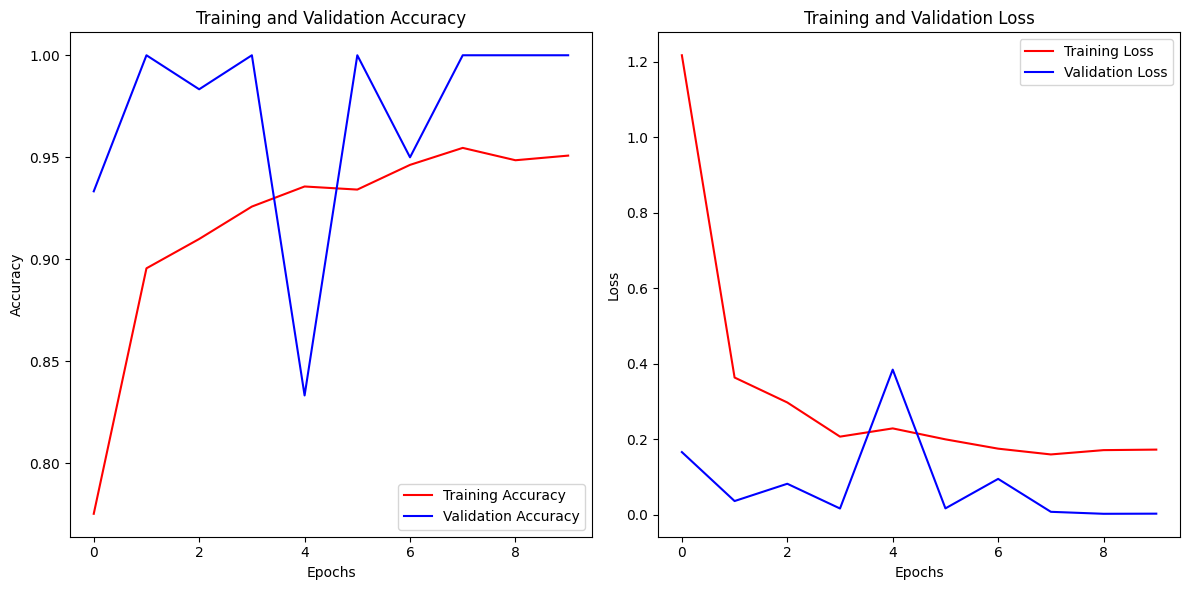

In [17]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Adjust layout and display plots
plt.tight_layout()
plt.show()

FileUpload(value=(), description='Upload', multiple=True)

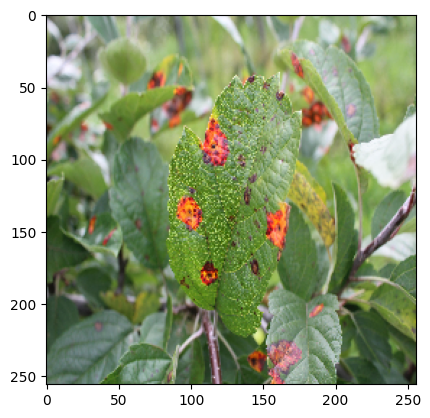

1/1 [==============================] - 0s 42ms/step
This is likely Rust with probability 100.00%


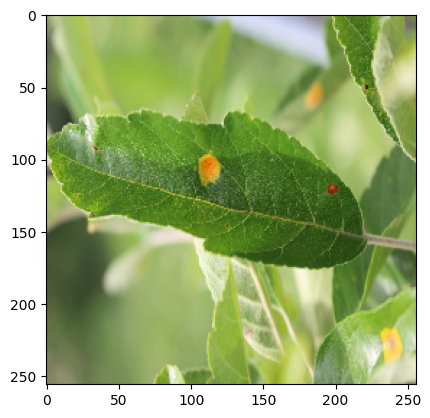

1/1 [==============================] - 0s 41ms/step
This is likely Rust with probability 100.00%


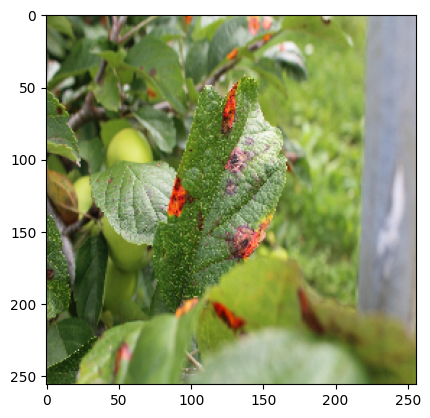

1/1 [==============================] - 0s 41ms/step
This is likely Rust with probability 100.00%


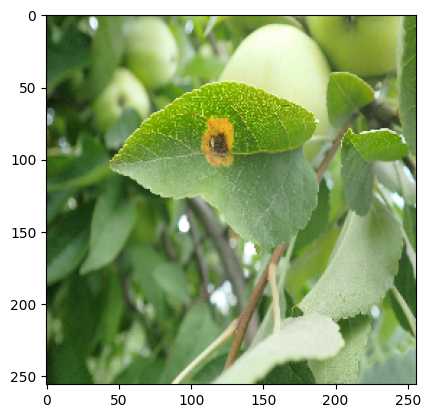

1/1 [==============================] - 0s 37ms/step
This is likely Rust with probability 100.00%


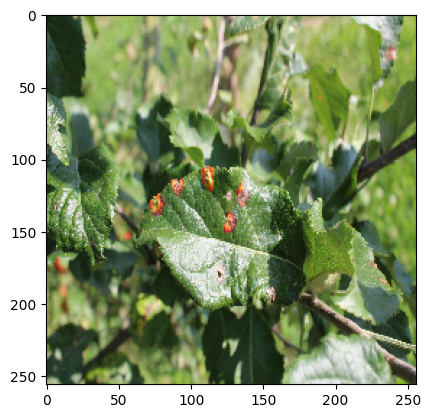

1/1 [==============================] - 0s 36ms/step
This is likely Rust with probability 100.00%


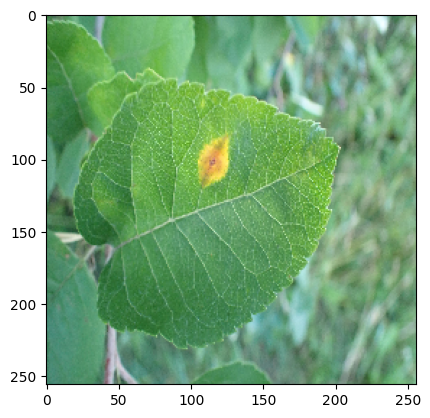

1/1 [==============================] - 0s 40ms/step
This is likely Rust with probability 100.00%


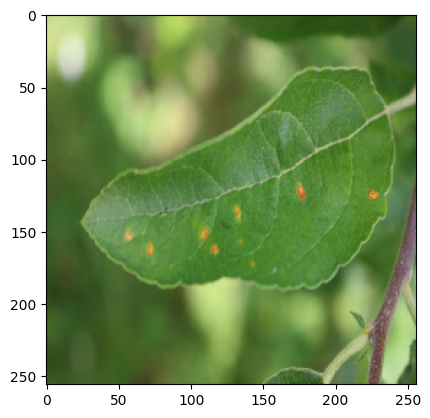

1/1 [==============================] - 0s 34ms/step
This is likely Rust with probability 100.00%


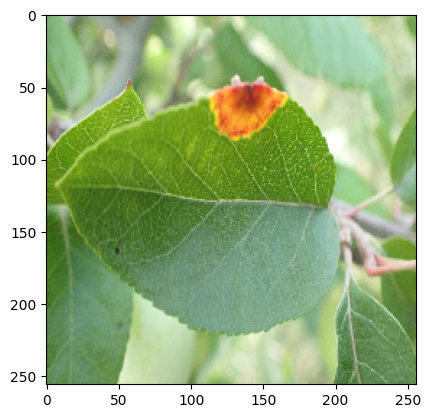

1/1 [==============================] - 0s 34ms/step
This is likely Rust with probability 91.55%


In [19]:
import numpy as np
from ipywidgets import FileUpload
from tensorflow.keras.utils import load_img, img_to_array
import tempfile
import matplotlib.pyplot as plt  # Make sure to import matplotlib for displaying the image

# Create a file uploader widget
uploader = FileUpload(multiple=True)
display(uploader)

def on_upload_complete(change):
    for uploaded_file in uploader.value:
        with tempfile.NamedTemporaryFile(delete=False) as temp_file:
            temp_file.write(uploaded_file['content'])  # Write the file data using 'content'
            temp_file.flush()  # Ensure data is written to the file
            filename = temp_file.name  # Now filename contains the full path

            # Process the image
            img = load_img(filename, target_size=(256, 256))
            plt.imshow(img)
            plt.show()  # Display the image
            x = img_to_array(img)
            x /= 255
            x = np.expand_dims(x, axis=0)
            images = np.vstack([x])

            # Assuming your model output is an array of probabilities for each class
            probabilities = model.predict(images, batch_size=10)[0]

            # Replace the following with your actual class names
            class_names = ['Healthy', 'Powdery', 'Rust']

            # Get the predicted class index
            predicted_class_index = np.argmax(probabilities)

            # Print the result
            print(f'This is likely {class_names[predicted_class_index]} with probability {probabilities[predicted_class_index]:.2%}')

uploader.observe(on_upload_complete, names='value')
